In [1]:
# Parameters
project_folder = "../.."
solution_columns = ["network_id", "strategy", "step", "source_node", "current_node", "reward", "total_reward"]


# Rule

* in general always take the edge with the larger payoff
* however: take the first large loss (only the first)

NOTE: this notebook uses the not vectorized version of the reward network task environment (defined in `environment.py`).
To use the vectorized version please refer to `try_vectorization.ipynb`

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns
import os
import glob
import json
import random
import logging
sns.set_theme()

from environment import Reward_Network

In [3]:
# directory management
code_dir = os.path.join(project_folder,'reward-network-iii-algorithm')
data_dir = os.path.join(project_folder,'data','rawdata')
solutions_dir = os.path.join(project_folder,'data','solutions_100') # or solutions_test
to_log=False

### define agent class

In [21]:
class Rule_Agent:

    def __init__(self,strategy):

        # assert tests
        assert strategy in ['highest_payoff','take_first_loss','random'], f'Strategy name must be one of {["highest_payoff","take_first_loss","random"]}, got {strategy}'
        
        self.strategy =  strategy        
        self.colors = {'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}


    def select_action(self,possible_actions,possible_actions_rewards):
        """
        This method selects an action to take in the environment based on current strategy
        """

        if self.strategy == 'take_first_loss':
            print(self.strategy,self.loss_counter,possible_actions_rewards)

        if self.strategy=='random':
            return random.choice(possible_actions)

        # take first loss -> select among possible actions the one that gives best reward BUT make sure to take a first big loss
        if self.strategy == 'take_first_loss' and self.loss_counter<1 and -100 in possible_actions_rewards:
            self.loss_counter +=1
            print(f'where is -100 loss: {np.argwhere(possible_actions_rewards==-100)[0][0]}')

            if len(np.argwhere(possible_actions_rewards==-100)[0])!=2: # that is, we have only one big loss in the possible actions
                print('only one big loss')
                return possible_actions[np.argwhere(possible_actions_rewards==-100)[0][0]]
            else: # else if both actions lead to big loss pick a random one
                print('two big losses, select one action at random')
                return possible_actions[random.choice(np.argwhere(possible_actions_rewards==-100)[0])]
        else:
            # highest payoff -> select among possible actions the one that gives best reward
            #print(f'take highest payoff {self.possible_actions[np.argmax(self.possible_actions_rewards)]}')
            #print('\n')
            try:
                print(f'rewards: {possible_actions_rewards}')
                if not np.all(possible_actions_rewards == possible_actions_rewards[0]):
                    print(f'choose: {np.argmax(possible_actions_rewards)}')
                    return possible_actions[np.argmax(possible_actions_rewards)]
                else:
                    print(f'choose random')
                    return random.choice(possible_actions)
            except:
                print('Error')
                print(self.environment.id)
                print(self.environment.action_space)

    def solve(self,network):
        """ 
        the agent solves the task, with different constraints depending on the strategy.
        Returns solved reward network in tabular form
        """
        if self.strategy == 'take_first_loss':
            self.loss_counter = 0 # to reset!

        self.solution = []
        self.solution_filename = os.path.join(solutions_dir,f'{network["network_id"]}_Solution_log_{self.strategy}_viz_100.csv')    
        
        self.environment = Reward_Network(network)
        self.environment.reset()
        print(self.environment.get_state())
        print(self.environment.observe())
        
        while self.environment.is_done==False:
            s = []
            obs = self.environment.observe()
            #a = self.select_action()
            a = self.select_action(obs['actions_available'],obs['next_possible_rewards'])
            step = self.environment.step(a)
            #obs = self.environment.step(a)
            s.append(self.environment.id)
            s.append(self.strategy)
            s.append(step['n_steps'])
            s.append(step['source_node'])
            s.append(step['current_node'])
            s.append(step['reward'])
            s.append(step['total_reward'])
            self.solution.append(s)
        print('\n')
        self.solution_df = pd.DataFrame(self.solution, columns = solution_columns)
        self.solution_df.to_csv(self.solution_filename,sep='\t')

    def save_solutions(self):
        self.all_solutions_filename = os.path.join(solutions_dir,f'{self.strategy}_train_viz_100.csv')
        self.solutions_fn = glob.glob(solutions_dir+f'/*{self.strategy}_viz_100.csv') #f'/*{self.strategy}*.csv')
        self.df = pd.concat([pd.read_csv(s,sep='\t') for s in self.solutions_fn],ignore_index=True)
        self.df[solution_columns].to_csv(self.all_solutions_filename,sep='\t')

    def inspect_solutions(self):
        self.df = pd.read_csv(os.path.join(solutions_dir,f'{self.strategy}_train_viz_100.csv'),sep='\t')
        g = sns.displot(data=self.df[self.df['step']==8], x="total_reward", kde=True, color=self.colors[self.strategy])
        g.set(xlim=(-400,400),xlabel='Final reward',ylabel='Count')
        plt.show()

## Solve networks + compare strategies' results

In [22]:
with open(os.path.join(data_dir,'train_viz_100.json')) as json_file: # or train_viz_test.json
    train = json.load(json_file)
print(f'NUMBER OF NETWORKS FOUND IN TRAIN.JSON: {len(train)}')

NUMBER OF NETWORKS FOUND IN TRAIN.JSON: 948


In [23]:
print("-------A (highest payoff)-------")
A = Rule_Agent('highest_payoff')

for network in train:
    A.solve(network)
print('\n')

-------A (highest payoff)-------
{'current_node': 0, 'total_reward': 0, 'n_steps': 0, 'done': False}
{'current_node': 0, 'actions_available': [{'source_num': 0, 'target_num': 2, 'reward': 0, 'arc_type': 'straight', 'source_x': 78.60791709619677, 'source_y': 51.719007092079416, 'arc_x': 55.90185749114518, 'arc_y': -18.163066320503816, 'target_x': 33.30514980997447, 'target_y': -87.70858908073387}, {'source_num': 0, 'target_num': 3, 'reward': 20, 'arc_type': 'curved', 'source_x': 73.85337749760319, 'source_y': 51.11665523448442, 'arc_x': 8.35430247894835, 'arc_y': -18.732512603763873, 'target_x': -71.72640589852821, 'target_y': -54.76804963589077}], 'next_possible_nodes': array([2, 3]), 'next_possible_rewards': array([ 0, 20]), 'total_reward': 0, 'n_steps': 0, 'done': False}
rewards: [ 0 20]
choose: 1
rewards: [20 20]
choose random
rewards: [ 0 20]
choose: 1
rewards: [20 20]
choose random
rewards: [-100   20]
choose: 1
rewards: [20 20]
choose random
rewards: [ 0 20]
choose: 1
rewards: [2

In [24]:
print("-------B (take_first_loss)-------")
B = Rule_Agent('take_first_loss')

for network in train:
    B.solve(network)
print('\n')

-------B (take_first_loss)-------
{'current_node': 0, 'total_reward': 0, 'n_steps': 0, 'done': False}
{'current_node': 0, 'actions_available': [{'source_num': 0, 'target_num': 2, 'reward': 0, 'arc_type': 'straight', 'source_x': 78.60791709619677, 'source_y': 51.719007092079416, 'arc_x': 55.90185749114518, 'arc_y': -18.163066320503816, 'target_x': 33.30514980997447, 'target_y': -87.70858908073387}, {'source_num': 0, 'target_num': 3, 'reward': 20, 'arc_type': 'curved', 'source_x': 73.85337749760319, 'source_y': 51.11665523448442, 'arc_x': 8.35430247894835, 'arc_y': -18.732512603763873, 'target_x': -71.72640589852821, 'target_y': -54.76804963589077}], 'next_possible_nodes': array([2, 3]), 'next_possible_rewards': array([ 0, 20]), 'total_reward': 0, 'n_steps': 0, 'done': False}
take_first_loss 0 [ 0 20]
rewards: [ 0 20]
choose: 1
take_first_loss 0 [20 20]
rewards: [20 20]
choose random
take_first_loss 0 [-100   20]
where is -100 loss: 0
only one big loss
take_first_loss 1 [20  0]
rewards: 

In [25]:
print("-------C (random)-------")
C = Rule_Agent('random')

for network in train:
    C.solve(network)
print('\n')

-------C (random)-------
{'current_node': 0, 'total_reward': 0, 'n_steps': 0, 'done': False}
{'current_node': 0, 'actions_available': [{'source_num': 0, 'target_num': 2, 'reward': 0, 'arc_type': 'straight', 'source_x': 78.60791709619677, 'source_y': 51.719007092079416, 'arc_x': 55.90185749114518, 'arc_y': -18.163066320503816, 'target_x': 33.30514980997447, 'target_y': -87.70858908073387}, {'source_num': 0, 'target_num': 3, 'reward': 20, 'arc_type': 'curved', 'source_x': 73.85337749760319, 'source_y': 51.11665523448442, 'arc_x': 8.35430247894835, 'arc_y': -18.732512603763873, 'target_x': -71.72640589852821, 'target_y': -54.76804963589077}], 'next_possible_nodes': array([2, 3]), 'next_possible_rewards': array([ 0, 20]), 'total_reward': 0, 'n_steps': 0, 'done': False}


{'current_node': 0, 'total_reward': 0, 'n_steps': 0, 'done': False}
{'current_node': 0, 'actions_available': [{'source_num': 0, 'target_num': 3, 'reward': -20, 'arc_type': 'curved', 'source_x': -74.69033267977193, 'source_

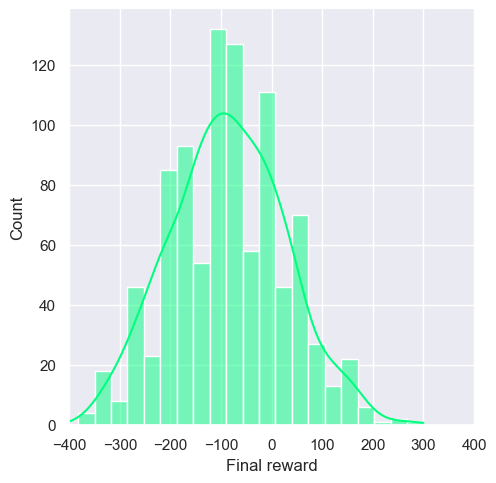

In [28]:
C.save_solutions()
C.inspect_solutions()

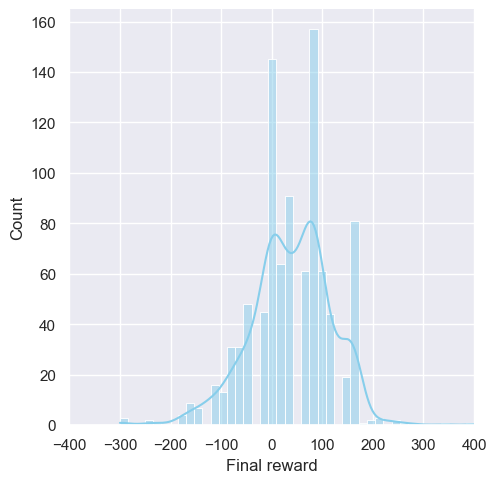

In [9]:
A.save_solutions()
A.inspect_solutions()

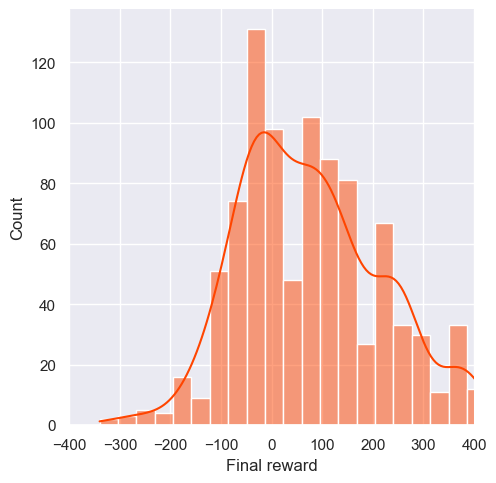

In [10]:
B.save_solutions()
B.inspect_solutions()

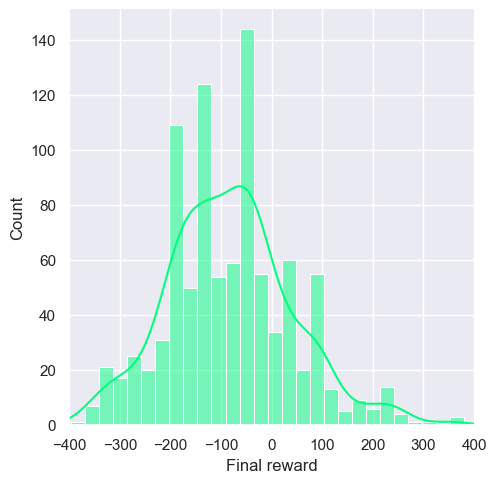

In [11]:
C.save_solutions()
C.inspect_solutions()

## analyze solution final rewards and compare the different strategies

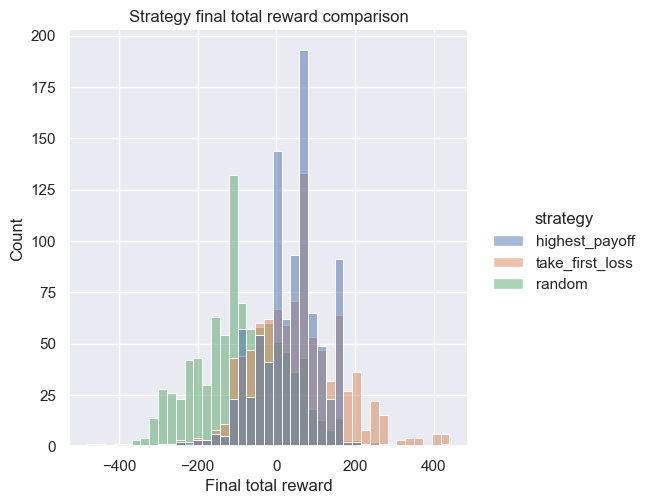

In [29]:
if os.path.exists(A.all_solutions_filename) and os.path.exists(B.all_solutions_filename) and os.path.exists(C.all_solutions_filename):
    
    # load solution data 
    strategy_A = pd.read_csv(A.all_solutions_filename,sep='\t')
    strategy_B = pd.read_csv(B.all_solutions_filename,sep='\t')
    strategy_C = pd.read_csv(C.all_solutions_filename,sep='\t')
    # create solution data file with all strategies in one file 
    strategy_data = pd.concat([strategy_A,strategy_B,strategy_C],ignore_index=True)[solution_columns]
    strategy_data_final=strategy_data[strategy_data['step']==8]
    strategy_data.to_csv(os.path.join(solutions_dir,'ALL_SOLUTIONS_100.csv'),sep='\t')

    # hist plot
    g=sns.displot(data=strategy_data_final, x="total_reward", hue="strategy", kind="hist")
    g.set(xlabel='Final total reward',ylabel='Count',title=f'Strategy final total reward comparison')
    plt.show()

In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=strategy_data_final['total_reward'],
                          groups=strategy_data_final['strategy'],
                          alpha=0.05)

#display results
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1          group2      meandiff p-adj    lower     upper   reject
--------------------------------------------------------------------------
highest_payoff          random -123.7342    0.0 -135.0228 -112.4456   True
highest_payoff take_first_loss   16.1181 0.0024    4.8295   27.4067   True
        random take_first_loss  139.8523    0.0  128.5637  151.1409   True
--------------------------------------------------------------------------


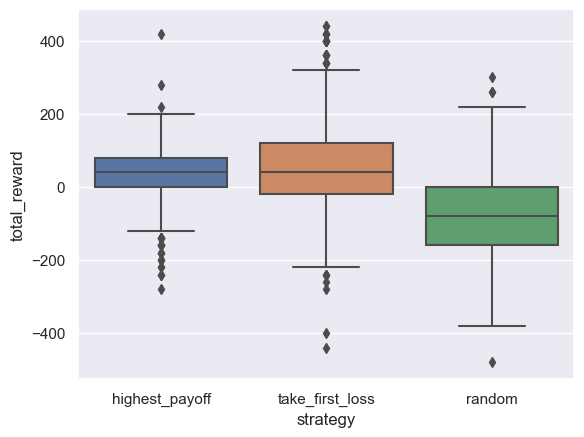

In [31]:
sns.boxplot(x="strategy", y="total_reward", data=strategy_data_final)
plt.show()

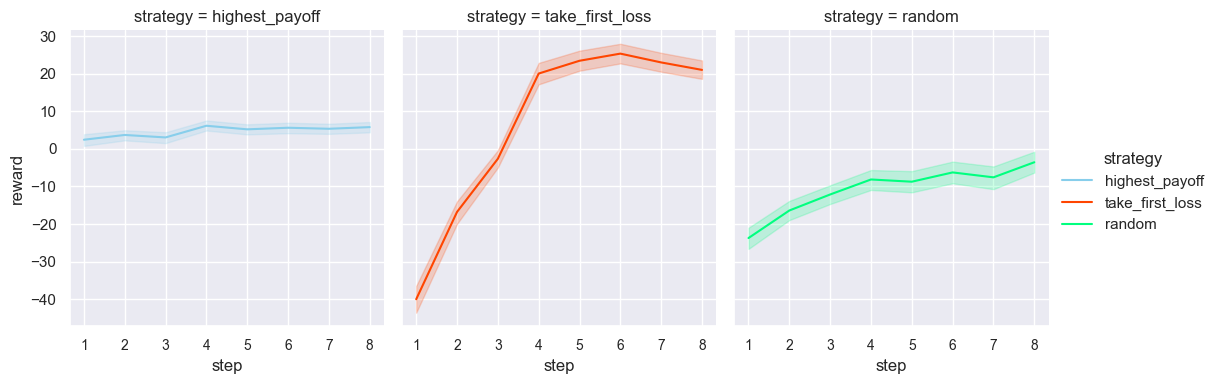

In [32]:
g = sns.relplot(
    data=strategy_data,
    x="step", y="reward", col='strategy',hue='strategy',
    height=4, aspect=.9, kind="line",palette={'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}
)
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=[1,2,3,4,5,6,7,8]) # set new labels
    ax.set_xticklabels(fontsize=10,labels=[str(i) for i in range(1,9)])
plt.show()

## inspect solutions more closely

In [16]:
strategy_A = pd.read_csv(A.all_solutions_filename,sep='\t')[solution_columns]
strategy_B = pd.read_csv(B.all_solutions_filename,sep='\t')[solution_columns]
strategy_C = pd.read_csv(C.all_solutions_filename,sep='\t')[solution_columns]

strategy_A_wide = strategy_A.pivot_table(index="network_id", columns="step", values="reward")
strategy_A_wide.head(30)

step,1,2,3,4,5,6,7,8
network_id,,,,,,,,
00410276e70accc13bfd7578d87c78de,0,0,0,0,0,0,0,0
0048efba60f9b6335e067c5ce2982301,20,0,20,20,0,20,-20,0
005a0469c0255b383e35be241e554ee4,20,0,20,20,20,20,20,20
00aa6f6cafbc5bef04b3ba4e22f0b713,0,20,0,20,0,20,0,20
00d73c107f590b88ea7ac44657ba64f4,-20,20,20,0,20,20,0,20
0108626dbc023fda78182cbd9b880bd4,-20,0,-20,0,-20,0,-20,0
0179df9889f8a766942a0d5971e9fd88,0,20,20,20,0,20,20,20
017a08d865a682b064023b59fc8120d1,0,20,-20,0,0,20,-20,0
020ada386d28958db0c4d18c816e7fc2,0,20,0,20,20,0,20,0


In [17]:
strategy_B_wide = strategy_B.pivot_table(index="network_id", columns="step", values="reward")
strategy_B_wide.head(30)

step,1,2,3,4,5,6,7,8
network_id,,,,,,,,
00410276e70accc13bfd7578d87c78de,0,0,0,0,-100,20,20,20
0048efba60f9b6335e067c5ce2982301,20,0,20,-100,20,20,140,140
005a0469c0255b383e35be241e554ee4,-100,20,0,20,20,20,20,20
00aa6f6cafbc5bef04b3ba4e22f0b713,0,-100,0,20,20,20,0,20
00d73c107f590b88ea7ac44657ba64f4,-100,20,0,140,0,-20,20,20
0108626dbc023fda78182cbd9b880bd4,-100,20,0,140,140,20,20,-20
0179df9889f8a766942a0d5971e9fd88,-100,20,0,0,20,20,20,0
017a08d865a682b064023b59fc8120d1,0,20,-100,20,0,20,140,20
020ada386d28958db0c4d18c816e7fc2,-100,20,20,140,20,140,20,140


In [18]:
strategy_C_wide = strategy_C.pivot_table(index="network_id", columns="step", values="reward")
strategy_C_wide.head(30)

step,1,2,3,4,5,6,7,8
network_id,,,,,,,,
00410276e70accc13bfd7578d87c78de,-20,-100,20,20,20,0,20,0
0048efba60f9b6335e067c5ce2982301,-20,-20,20,20,-20,-20,-20,-20
005a0469c0255b383e35be241e554ee4,20,-20,-100,20,0,20,20,20
00aa6f6cafbc5bef04b3ba4e22f0b713,0,20,0,20,0,20,-20,0
00d73c107f590b88ea7ac44657ba64f4,-20,20,20,0,0,-20,20,-100
0108626dbc023fda78182cbd9b880bd4,-100,20,0,0,20,-20,-20,-20
0179df9889f8a766942a0d5971e9fd88,0,-100,20,0,-100,20,0,-100
017a08d865a682b064023b59fc8120d1,-20,-100,20,0,20,140,20,0
020ada386d28958db0c4d18c816e7fc2,-100,0,0,-100,20,0,0,0


In [19]:
strategy_A_wide.mean(axis=0)

step
1    3.365079
2    1.735450
3    4.486772
4    3.788360
5    7.576720
6    4.719577
7    6.582011
8    5.862434
dtype: float64

In [20]:
strategy_B_wide.mean(axis=0)

step
1   -34.116402
2   -20.804233
3    -3.005291
4    24.380952
5    30.687831
6    29.439153
7    29.291005
8    28.063492
dtype: float64

In [21]:
strategy_C_wide.mean(axis=0)

step
1   -21.396825
2   -17.037037
3   -14.137566
4    -8.740741
5    -5.841270
6    -4.952381
7    -4.719577
8    -5.312169
dtype: float64

### What is the average number of points collected for each of the investigated strategies?

In [24]:
import numpy as np
import pandas as pd
import os
project_dir = '../..'
solutions_dir = os.path.join(project_folder,'data','solutions_test')

highest_payoff = pd.read_csv(os.path.join(solutions_dir,'highest_payoff_train.csv'),sep='\t')
take_first_loss = pd.read_csv(os.path.join(solutions_dir,'take_first_loss_train.csv'),sep='\t')
random = pd.read_csv(os.path.join(solutions_dir,'random_train.csv'),sep='\t')
random.columns

Index(['Unnamed: 0', 'network_id', 'strategy', 'step', 'source_node',
       'current_node', 'reward', 'total_reward'],
      dtype='object')

In [25]:
print(f"average final reward (random strategy): {random[random['step']==8]['total_reward'].mean()}")
print(f"average final reward (highest payoff strategy): {highest_payoff[highest_payoff['step']==8]['total_reward'].mean()}")
print(f"average final reward (take first loss strategy): {take_first_loss[take_first_loss['step']==8]['total_reward'].mean()}")

average final reward (random strategy): -82.13756613756614
average final reward (highest payoff strategy): 38.116402116402114
average final reward (take first loss strategy): 83.93650793650794


### Rearrange the solutions file into JSON format
We store network_id + list of moves 

In [33]:
if os.path.exists(os.path.join(solutions_dir,'take_first_loss_train_viz_100.csv')):
    df = pd.read_csv(os.path.join(solutions_dir,'take_first_loss_train_viz_100.csv'),sep='\t')


def add_source(x):
    a=x
    a.insert(0,0)
    return a
s = df.groupby(['network_id'])['current_node'].apply(list).reset_index(name='moves')
s['moves'] = s['moves'].apply(add_source)
s

,network_id,moves
0,000739d41ee6b0089d16e3e140b4669d,"[0, 1, 3, 4, 5, 8, 9, 7, 8]"
1,004b6ee3bbc92c16f25d4adcb06ab614,"[0, 2, 1, 2, 1, 2, 1, 0, 2]"
2,00effa93af6bd90e0f3d55a7eb7441cc,"[0, 2, 5, 4, 6, 9, 8, 4, 6]"
3,0112b67984838af4898e16be3537d72d,"[0, 3, 0, 3, 0, 3, 0, 3, 2]"
4,013134bbf8ccc66685f19f84be501256,"[0, 1, 5, 6, 8, 9, 8, 9, 8]"
...,...,...
943,fe6de0f3bd8f5c6924326627d0f1c57a,"[0, 1, 2, 0, 1, 2, 0, 1, 2]"
944,fe7a432e0f2400c1fd78a8812537ded3,"[0, 5, 0, 1, 3, 0, 1, 3, 0]"
945,ff073cddc92ad9ee4cc3477b589b6457,"[0, 3, 1, 2, 5, 6, 9, 6, 9]"
946,ffa6d717c44a0fe2d183e9b35c24e4a2,"[0, 4, 6, 8, 6, 7, 5, 9, 5]"


In [34]:
len(df['network_id'].unique())

948

In [37]:
for n in train:
    if n['network_id']=='000739d41ee6b0089d16e3e140b4669d':
        print(n)

{'network_id': '000739d41ee6b0089d16e3e140b4669d', 'nodes': [{'node_num': 0, 'display_name': 'A', 'node_size': 3, 'level': 0, 'x': -30.901702458252295, 'y': -95.10564894417183}, {'node_num': 1, 'display_name': 'B', 'node_size': 3, 'level': 0, 'x': -30.901711398948954, 'y': 95.10564600362343}, {'node_num': 2, 'display_name': 'C', 'node_size': 3, 'level': 0, 'x': 100.0, 'y': -1.4702742047251474e-06}, {'node_num': 3, 'display_name': 'D', 'node_size': 3, 'level': 0, 'x': -80.9016932195324, 'y': 58.77852853864663}, {'node_num': 4, 'display_name': 'E', 'node_size': 3, 'level': 0, 'x': -80.90169917999684, 'y': -58.7785255187306}, {'node_num': 5, 'display_name': 'F', 'node_size': 3, 'level': 1, 'x': 80.90169441162529, 'y': 58.77852853864663}, {'node_num': 6, 'display_name': 'G', 'node_size': 3, 'level': 2, 'x': 30.901712591041843, 'y': 95.10564600362343}, {'node_num': 7, 'display_name': 'H', 'node_size': 3, 'level': 2, 'x': 30.901697689880734, 'y': -95.10565490463628}, {'node_num': 8, 'display

In [35]:
obj = s.to_dict('records')

with open(os.path.join(solutions_dir,'solution_moves_take_first_loss_100.json'), 'w') as f:
    json.dump(obj, f)

## Check if strategies are still separated in terms of expected performance

Loading strategy data from ../../data/solutions_100/ALL_SOLUTIONS_100.csv


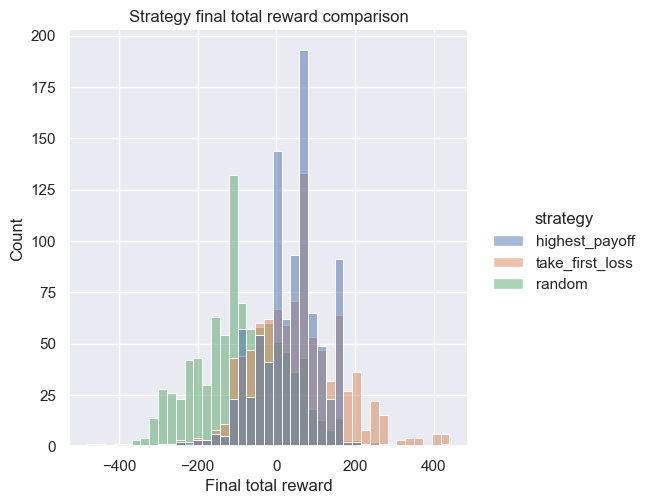

In [8]:
print(f'Loading strategy data from {os.path.join(solutions_dir,"ALL_SOLUTIONS_100.csv")}')
strategy_data = pd.read_csv(os.path.join(solutions_dir,'ALL_SOLUTIONS_100.csv'),sep='\t')
strategy_data_final=strategy_data[strategy_data['step']==8]

# hist plot
g=sns.displot(data=strategy_data_final, x="total_reward", hue="strategy", kind="hist")
g.set(xlabel='Final total reward',ylabel='Count',title=f'Strategy final total reward comparison')
plt.show()

In [9]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=strategy_data_final['total_reward'],
                          groups=strategy_data_final['strategy'],
                          alpha=0.05)

#display results
print(tukey)

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
    group1          group2      meandiff p-adj    lower     upper   reject
--------------------------------------------------------------------------
highest_payoff          random -123.7342    0.0 -135.0228 -112.4456   True
highest_payoff take_first_loss   16.1181 0.0024    4.8295   27.4067   True
        random take_first_loss  139.8523    0.0  128.5637  151.1409   True
--------------------------------------------------------------------------


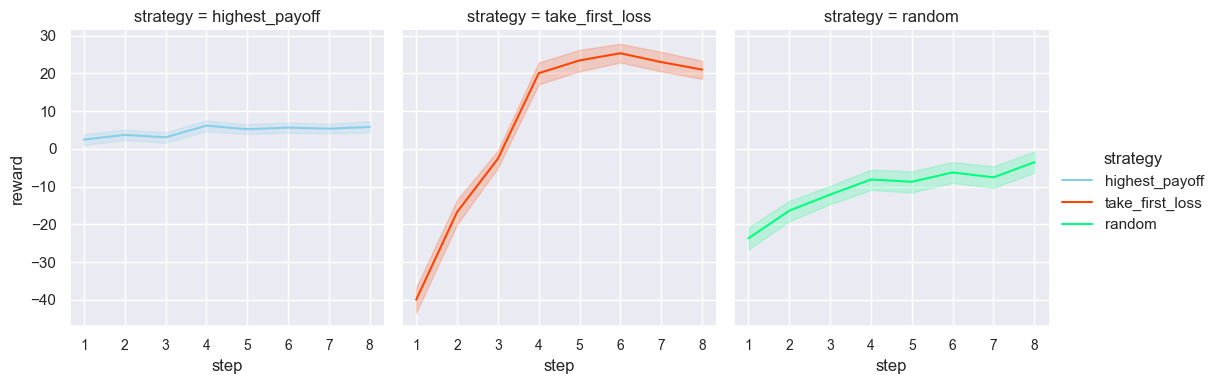

In [10]:
g = sns.relplot(
    data=strategy_data,
    x="step", y="reward", col='strategy',hue='strategy',
    height=4, aspect=.9, kind="line",palette={'highest_payoff':'skyblue','take_first_loss':'orangered','random':'springgreen'}
)
for ax in g.axes.flat:
    labels = ax.get_xticklabels() # get x labels
    ax.set_xticks(ticks=[1,2,3,4,5,6,7,8]) # set new labels
    ax.set_xticklabels(fontsize=10,labels=[str(i) for i in range(1,9)])
plt.show()